In [1]:
%pylab inline
from __future__ import division
from copy import deepcopy as dc
import statsmodels.formula.api as smf
import numpy as np
import random as rd
import pylab as pl
import pandas as pd
import networkx as nx
import time
pl.rcParams.update({'font.size':15,'font.family':"STIXGeneral",'mathtext.fontset':'stix'})

Populating the interactive namespace from numpy and matplotlib


In [2]:
class Diffuse: #默认网络结构为节点数量为10000，边为60000的单向随机网络
    G = nx.gnm_random_graph(10000,30000).to_directed()
    repetes = 10 #默认多次扩散重复次数
    v1 = 0
    v2 = 0
    def __init__(self,p,q,num_runs):
        self.num_runs = num_runs
        self.DG = dc(self.G) #取网络的深层copy，以使原网络不被“污染”
        self.p = p
        self.q = q
        for i in self.DG.nodes():
            self.DG[i]['prede'] = self.DG.predecessors(i)
        
    def decision(self,i): #个体状态决策规则
        influ = len([k for k in self.DG[i].get('prede',[]) if self.DG[k]['state'] == 1])           
        prob = self.DG[i]['p'] + self.DG[i]['q']*influ
        if rd.random() <= prob:
            return True
        else:
            return False
        
    def single_diffuse(self): #单次扩散
        for i in self.DG.nodes():
            self.DG[i]['state'] = 0
            self.DG[i]['p'] = self.p*(1+self.v1*np.random.randn())
            self.DG[i]['q'] = self.q*(1+self.v2*np.random.randn())
            
        non_adopt_set = [i for i in self.DG.nodes() if self.DG[i]['state'] == 0]
        num_of_adopt = []
        j = 1 
        while j <= self.num_runs:                                 
            x = 0
            rd.shuffle(non_adopt_set)
            for i in non_adopt_set:                   
                if self.decision(i):
                    self.DG[i]['state'] = 1
                    non_adopt_set.remove(i)
                    x = x+1
            num_of_adopt.append(x)
            j = j+1

        return num_of_adopt
    
    def repete_diffuse(self): #多次扩散
        adopt_cont = []
        for i in range(self.repetes):
            num_of_adopt = self.single_diffuse()
            adopt_cont.append(num_of_adopt)
        return adopt_cont

### 生成扩散数据集，用于拟合数据

In [3]:
pq_range = [(i,j) for i in np.arange(0.0005,0.0255,0.001) for j in np.arange(0.02,0.2,0.003)] #25*60=1500

In [132]:
sigma_cont = [0.1,0.2,0.4,0.6,0.8,1,1.2]
for sigma in sigma_cont:
    time1 = time.clock()
    print '-------------------%s---------------------'%sigma
    diff_cont =[]
    k = 1
    for p,q in pq_range:
        diff = Diffuse(p,q,25)
        diff.v1,diff.v2 = sigma,sigma
        temp = diff.repete_diffuse()
        x = np.mean(temp,axis=0)
        x = np.insert(x,0,[p,q])
        diff_cont.append(x)
        k = k+1
        if k in [100,400,800,1200,1400]:
            print '%s'%text_set[u],k,'runs:',time.clock()-time1,'s'
            time1 = time.clock()
        
        to_write = np.array(diff_cont)
        np.save("diffusion data set for sigma-%s"%sigma,to_write)

12.5876124769 s


### 扩散实例

20


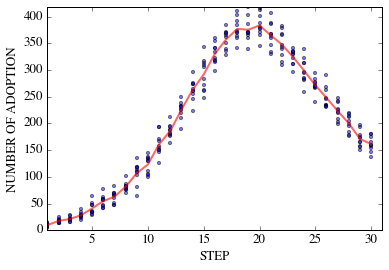

In [133]:
mean_a = np.mean(a,axis=0)
print np.argmax(mean_a)+1
for x in a:
    pl.scatter(np.arange(1,31),x,s=10,marker='o',c='b',alpha=0.5)
pl.plot(np.arange(1,31),mean_a,'r',lw=2,alpha=0.6)
pl.xlim(1,31)
pl.ylim(0,np.max(a))
pl.xlabel('STEP')
pl.ylabel('NUMBER OF ADOPTION')

In [ ]:
v_cont = [0,0.1,0.2,0.4,0.6,0.8,1]
d_cont = []
diff = Diffuse(0.005,0.1,25)
for v in v_cont:
    diff.v1 = v
    diff.v2 = v
    a = diff.repete_diffuse()
    d_cont.append(np.mean(a,axis=0))

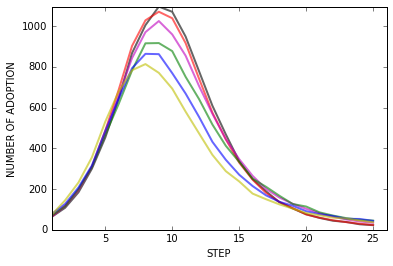

In [96]:
c_cont = ['k','r','m','g','b','y']
for i in range(6):
    pl.plot(np.arange(1,26),d_cont[i],c_cont[i],lw=2,alpha=0.6)
    
pl.xlim(1,26)
pl.ylim(0,np.max(d_cont))
pl.xlabel('STEP')
pl.ylabel('NUMBER OF ADOPTION')

###  （1）生成ABM扩散数据

In [135]:
v_cont = [0,0.1,0.2,0.4,0.6,0.8,1,1.2]
p_cont = [i*0.005+0.001 for i in range(5)]

q_cont0 = np.linspace(0.05,0.15,20) #v=0
q_cont1 = np.linspace(0.055,0.15,20) #v=0.1
q_cont2 = np.linspace(0.055,0.15,20) #v=0.2
q_cont3 = np.linspace(0.055,0.15,20) #v=0.4
q_cont4 = np.linspace(0.055,0.15,20) #v=0.6
q_cont5 = np.linspace(0.05,0.14,20) #v=0.8
q_cont6 = np.linspace(0.05,0.13,20) #v=1
q_cont7 = np.linspace(0.05,0.1,20) #v=1.2

q_cont = [q_cont0,q_cont1,q_cont2,q_cont3,q_cont4,q_cont5,q_cont6,q_cont7]

for v in v_cont:
    data_cont = []
    for p in p_cont:
        time1 = time.clock()
        for q in q_cont[v_cont.index(v)]:
            diff = Diffuse(p,q,30)
            diff.v1 = v
            diff.v2 = v
            s_estim = diff.repete_diffuse()
            s_estim_avr = np.mean(s_estim,axis=0)
            data_cont.append(np.concatenate(([p,q],s_estim_avr)))

        print 'p:',p,
        print 'Time elasped:',time.clock()-time1

    np.save("sigma-%s"%v,data_cont)

p: 0.001 Time elasped: 209.919355312
p: 0.006 Time elasped: 175.360733879
p: 0.011 Time elasped: 167.666434212
p: 0.016 Time elasped: 158.153758079
p: 0.021 Time elasped: 153.480839185
p: 0.001 Time elasped: 202.236718663
p: 0.006 Time elasped: 172.320773475
p: 0.011 Time elasped: 162.578619169
p: 0.016 Time elasped: 156.655634773
p: 0.021 Time elasped: 151.727315804
p: 0.001 Time elasped: 202.138462841
p: 0.006 Time elasped: 173.457451852
p: 0.011 Time elasped: 163.632820784
p: 0.016 Time elasped: 157.242896288
p: 0.021 Time elasped: 152.929820895
p: 0.001 Time elasped: 208.393263914
p: 0.006 Time elasped: 179.056586791
p: 0.011 Time elasped: 169.649856864
p: 0.016 Time elasped: 162.404470766
p: 0.021 Time elasped: 157.452711435
p: 0.001 Time elasped: 217.374723057
p: 0.006 Time elasped: 188.966566472
p: 0.011 Time elasped: 179.245329932
p: 0.016 Time elasped: 172.55177467
p: 0.021 Time elasped: 167.659075688
p: 0.001 Time elasped: 229.792204812
p: 0.006 Time elasped: 202.525862175
p:

### （2） 拟合

In [150]:
class Random_Grid_Search:
    t_n = 500 #抽样量
    c_n = 50 #保留参数量
    threshold = 1e-6 #循环停止阈值
    repetes = 1 #重复次数
    orig_points = [] #初始化边界点
    def __init__(self,s): #初始化实例参数
        self.s = np.array(s)  #待拟合曲线
        self.s_len = len(s)
        self.para_range = [[1e-6,0.1],[1e-3,1],[sum(s),5*sum(s)]]  #参数范围
        self.p_range = [[1e-6,0.1],[1e-3,1],[sum(s),5*sum(s)]]  #用于产生边界节点的参数范围 
    
    def genera_orig(self): #递归产生边界点
        if len(self.p_range) == 0:
            return
        else:  
            pa = self.p_range[-1]
            if self.orig_points == []:
                self.orig_points = [[pa[0]],[pa[1]]]  #初始化,排除orig_points为空的情形
            else:
                self.orig_points = [[pa[0]]+x for x in self.orig_points]+[[pa[1]]+x for x in self.orig_points]  #二分裂
            self.p_range.pop()
            return self.genera_orig()
    
    def sample(self,c_range): #抽样参数点
        p_list = []
        for pa in c_range:
            if isinstance(pa[0],float):
                x = (pa[1]-pa[0])*np.random.random(self.t_n) + pa[0]
            else:
                x = np.random.randint(low=pa[0],high=pa[1]+1,size=self.t_n)
            p_list.append(x)

        p_list = np.array(p_list).T
        return p_list.tolist()
    
    def f(self,params): #扩散函数
        diffu_cont = np.zeros(self.s_len)
        t_list = np.arange(1,self.s_len+1)
        a = np.array([1 - np.exp(-(params[0]+params[1])*t) for t in t_list])
        b = np.array([1 + params[1]/params[0]*np.exp(-(params[0]+params[1])*t) for t in t_list])
        diffu_cont = params[2]*a/b

        adopt_cont = np.zeros_like(diffu_cont)
        adopt_cont[0] = diffu_cont[0]
        for t in xrange(1,self.s_len):
            adopt_cont[t] = diffu_cont[t] - diffu_cont[t-1]

        return adopt_cont

    def mse(self,params):  #定义适应度函数（mse）
        a = self.f(params)
        tse = np.square(self.s-a)
        return np.mean(tse) #均方误
    
    def r2(self,params):
        a = np.array(self.f(params))
        tse = np.sum(np.square(self.s-a))
        mean_y = np.mean(self.s)
        ssl = np.sum(np.square(self.s-mean_y))
        return (ssl-tse)/ssl
    
    def optima_search(self):
        solution_cont = []
        self.genera_orig()
        
        for i in xrange(self.repetes):
            c_range = dc(self.para_range)
            samp = self.sample(c_range)
            solution = sorted([self.mse(x)]+x for x in samp+self.orig_points)[:self.c_n]
            u = 1
            while 1:
                params_min = np.min(np.array(solution),0) #最小值
                params_max = np.max(np.array(solution),0) #最大值
                c_range = [[params_min[j+1],params_max[j+1]] for j in range(len(c_range))] #重新定界
                samp = self.sample(c_range)
                solution = sorted([[self.mse(x)]+x for x in samp]+solution)[:self.c_n]
                r = sorted([x[0] for x in solution])
                v = (r[-1]-r[0])/r[0]
                if v < self.threshold:
                    break
                
                if u > 100:
                    print 'Searching ends in 100 runs'
                    break
                
                u += 1

            solution_cont.append(solution[0])

        solution = np.array(solution_cont)
        estimates = np.median(solution,axis=0)[1:]
        R2 = self.r2(estimates)
        return estimates,R2,solution
    
    def draw_curve(self,estms):
        f1 = self.f(estms)
        fig = pl.figure(figsize=(12,6))
        ax = fig.add_subplot(1,1,1)
        ax.plot(np.arange(1,self.s_len+1),self.s,'bo',label=r'$actual$')
        ax.plot(np.arange(1,self.s_len+1),f1,'r-',linewidth = 1.2,label=r'$fitted$')
        ax.set_title(r'Fitted and actual curve',fontsize=12)
        ax.set_xlabel(r'Time',fontsize=15)
        ax.set_ylabel(r'Sales',fontsize=15)
        ax.set_xlim([1,self.s_len])
        ax.legend(loc = 'best',fontsize=15)
        ax.grid(True) 

### s_coeff的数据结构[[p,q],[P,Q,M],R2]

In [161]:
for v in v_cont:
    coeff_cont = []
    time1 = time.clock()
    x_cont = np.load('sigma-%s.npy'%v)
    for x in x_cont:
        s_full = x[2:]
        max_idx = np.argmax(s_full)
        s = s_full[:max_idx+2]
        rgs = Random_Grid_Search(s)
        estim,r2=rgs.optima_search()[:2]
        s_coeff = [x[:2],estim,r2]
        coeff_cont.append(s_coeff)
    print 'Sigma=%s'%v
    print 'Time elasped: %.2f s'%(time.clock()-time1)
    np.save('estimate sigma-%s.npy'%v,coeff_cont)

Sigma=0
Time elasped: 73.99 s
Sigma=0.1
Time elasped: 73.57 s
Sigma=0.2
Time elasped: 73.86 s
Sigma=0.4
Time elasped: 72.12 s
Sigma=0.6
Time elasped: 70.62 s
Sigma=0.8
Time elasped: 71.43 s
Sigma=1
Time elasped: 70.09 s
Sigma=1.2
Time elasped: 72.86 s


### (3)绘图

In [3]:
coeff_cont_sigma_0 = np.load("estimate sigma-0.npy")
coeff_cont_sigma_1 = np.load("estimate sigma-0.1.npy")
coeff_cont_sigma_2 = np.load("estimate sigma-0.2.npy")
coeff_cont_sigma_4 = np.load("estimate sigma-0.4.npy")
coeff_cont_sigma_6 = np.load("estimate sigma-0.6.npy")
coeff_cont_sigma_8 = np.load("estimate sigma-0.8.npy")
coeff_cont_sigma_10 = np.load("estimate sigma-1.npy")
coeff_cont_sigma_12 = np.load("estimate sigma-1.2.npy")

In [4]:
d_cont2 = [coeff_cont_sigma_0,coeff_cont_sigma_1,coeff_cont_sigma_2,coeff_cont_sigma_4,
                       coeff_cont_sigma_6,coeff_cont_sigma_8,coeff_cont_sigma_10,coeff_cont_sigma_12]

### $R^2$

In [5]:
v_cont = [0,0.1,0.2,0.4,0.6,0.8,1,1.2]
for v in d_cont2:
    R2_set = [x[-1] for x in v]
    print 'sigma=%s'%v_cont[d_cont2.index(v)]
    print '    mean of r2:%.4f'%np.mean(R2_set)
    print '    std of r2:%.4f'%np.std(R2_set)

sigma=0
    mean of r2:0.9988
    std of r2:0.0011
sigma=0.1
    mean of r2:0.9988
    std of r2:0.0009
sigma=0.2
    mean of r2:0.9989
    std of r2:0.0008
sigma=0.4
    mean of r2:0.9986
    std of r2:0.0009
sigma=0.6
    mean of r2:0.9983
    std of r2:0.0018
sigma=0.8
    mean of r2:0.9984
    std of r2:0.0011
sigma=1
    mean of r2:0.9982
    std of r2:0.0012
sigma=1.2
    mean of r2:0.9983
    std of r2:0.0010


H:\Anaconda\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


#### 潜在市场容量

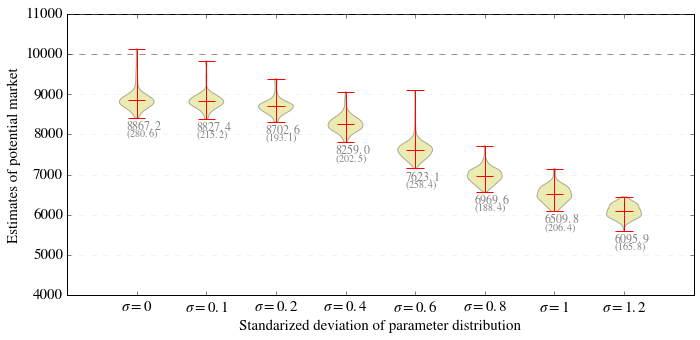

In [6]:
fig = pl.figure(figsize = (10,5))

ax = fig.add_subplot(1,1,1)
ax.axhline(10000,color='gray',ls = '--', lw = 1)
ax.set_ylim([4000,11000])
ax.set_xlabel('Standarized deviation of parameter distribution',fontsize=15)
ax.set_ylabel('Estimates of potential market',fontsize=15)

data = []
for v in d_cont2:
    M_set = [x[1][2] for x in v]
    data.append(M_set)
    
#ax.boxplot(data,notch=1,vert =1,whis=0,widths = 0.3,positions = [1, 2, 3, 4, 5, 6, 7, 8])
ax.violinplot(data,showmedians=False,showmeans=True,showextrema=True,widths = 0.5,positions=np.arange(1,9))
ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey',alpha=0.5)
for i in np.arange(1,9):
    ax.text(i-0.15,np.min(data[i-1])-200,r'$%.1f$'%np.mean(data[i-1]),
             fontsize=12, verticalalignment='center',color='k',alpha=0.5)
    ax.text(i-0.15,np.min(data[i-1])-400,r'$(%.1f)$'%np.std(data[i-1]),
             fontsize=10, verticalalignment='center',color='k',alpha=0.5)

pl.setp(ax,xticks=[1,2,3,4,5,6,7,8],
                        xticklabels=['$\sigma=0$','$\sigma=0.1$','$\sigma=0.2$','$\sigma=0.4$','$\sigma=0.6$','$\sigma=0.8$','$\sigma=1$','$\sigma=1.2$'])
pl.tight_layout()
pl.show()

#### p

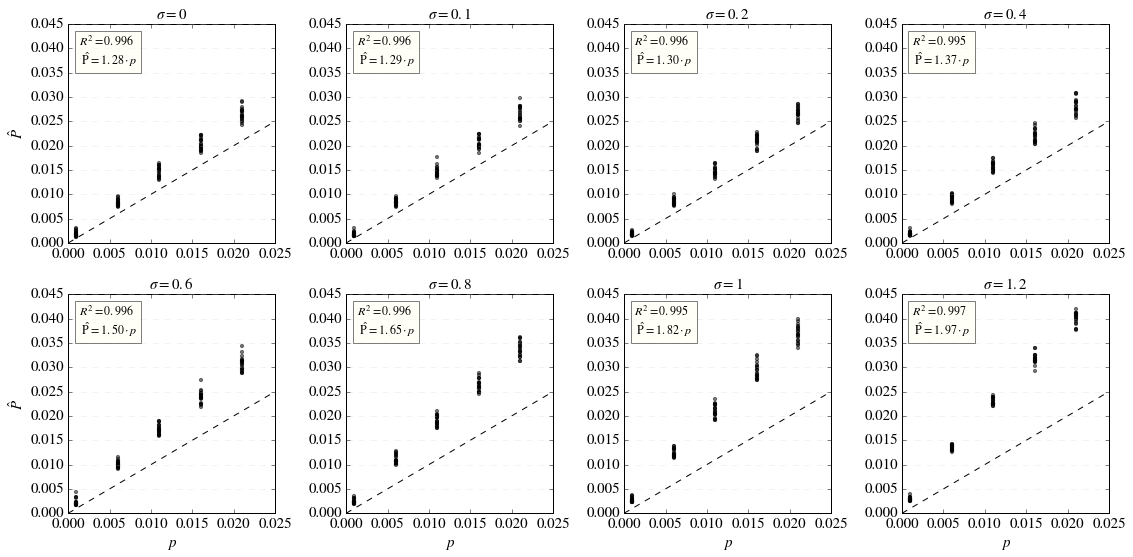

In [10]:
title = ['$\sigma=0$','$\sigma=0.1$','$\sigma=0.2$','$\sigma=0.4$','$\sigma=0.6$','$\sigma=0.8$','$\sigma=1$','$\sigma=1.2$']
fig = pl.figure(figsize=(16,8))
for j in range(8):
    ax = fig.add_subplot(2,4,j+1)
    X_data = np.array([x[0][0] for x in d_cont2[j]])
    Y_data = np.array([x[1][0] for x in d_cont2[j]])
    
    to_fit = pd.DataFrame({'X':X_data,'Y':Y_data})
    results = smf.ols('Y ~ X-1', data=to_fit).fit()
    a = results.params['X']
    r2 = results.rsquared
    
    ax.scatter(X_data,Y_data,s=10,marker='o',c = 'k',alpha=0.5)   
    textstr = '$R^2 = %.3f$ \n $\mathrm{\hat P} = %.2f\cdot p$'%(r2,a)
    props = dict(facecolor = 'ivory',alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)
    ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey',alpha=0.5)
    
    ax.plot([0,0.025],[0,0.025],'k--')
    ax.set_xlim([0,0.025])
    ax.set_ylim([0,0.045])
    ax.set_title(title[j],fontsize=15)
    
    if j >= 4:
        ax.set_xlabel('p',fontsize=15,style='italic')
    if j == 0 or j == 4:
        ax.set_ylabel('$\hat P$',fontsize=15,style='italic')
    '''
    if j < 4:
        ax.set_xticklabels([])
    if j in [1,2,3,5,6,7]:
        ax.set_yticklabels([])'''
    
pl.tight_layout()

#### q

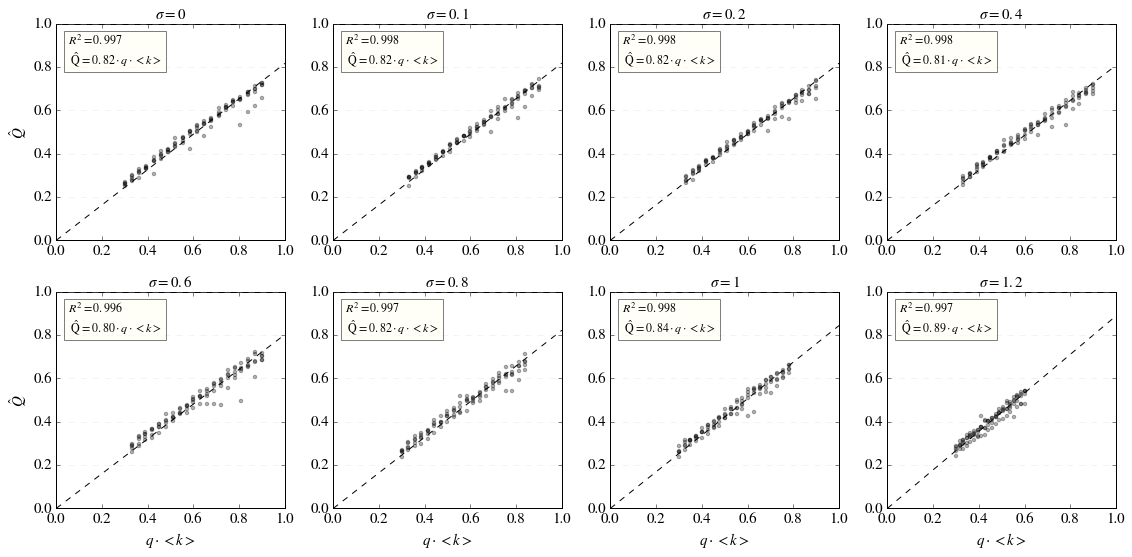

In [12]:
fig = pl.figure(figsize=(16,8))

for j in range(8):
    ax = fig.add_subplot(2,4,j+1)
    X_data = np.array([x[0][1] for x in d_cont2[j]])*6
    Y_data = np.array([x[1][1] for x in d_cont2[j]])
    to_fit = pd.DataFrame({'X':X_data,'Y':Y_data})
    results = smf.ols('Y ~ X-1', data=to_fit).fit()
    a = results.params['X']
    r2 = results.rsquared
    
    textstr = '$R^2 = %.3f$ \n $\mathrm{\hat Q} = %.2f\cdot q\cdot<k>$'%(r2,a)
    props = dict(facecolor = 'ivory',alpha=0.5)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.scatter(X_data,Y_data,c='k',marker='o',s=12,alpha=0.3)
    ax.plot([0,1],[0,a],'k--',lw = 1)
    ax.set_title(r'$\sigma=%s$'%(v_cont[j]),fontsize = 15,style='italic')
    ax.yaxis.grid(True, linestyle='--', which='major', color='lightgrey',alpha=0.5)
    if j >= 4: 
        ax.set_xlabel('$q \cdot <k>$',fontsize=15)
    if j == 0 or j == 4:
        ax.set_ylabel('$\hatQ$',fontsize=15)
    
    '''
    if j < 4:
        ax.set_xticklabels([])
    if j in [1,2,3,5,6,7]:
        ax.set_yticklabels([])'''

pl.tight_layout()